# Sequential Inference

This tutorial discusses particle filters, and sequential Monte Carlo more generally.

These techniques are relevant when performing inference on models where there is a large series of factor statements, some of which can be performed earlier than others. This situation often arises in time series models where the factor statements are the result of incoming observations, but the technique works for *any* probabilistic program.

As a motivating example, consider the following program:

In [1]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase


import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Free
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Sequential
import Control.Monad.Bayes.Inference.SMC

import qualified Graphics.Vega.VegaLite as VL
import IHaskell.Display.Hvega (vlShow)
import Control.Applicative
import qualified Data.Text as T
import Pipes (Producer, (>->))
import qualified Pipes as P
import Pipes.Prelude (unfoldr)
import qualified Pipes.Prelude as P
import Data.Ord
import Data.List
import Control.Monad
import Control.Arrow (first)

:l Plotting.hs

In [2]:
ex :: MonadInfer m => Int -> m [Bool]
ex n = replicateM n do
    x <- bernoulli 0.5
    condition x
    return x

What distribution does this represent? It is the distribution over all lists of Booleans of length $n$, which for e.g. $n=4$, places all the weight on the sequence `[True,True,True,True]`.



In [3]:
normalForm $ ex 4

[([True,True,True,True],6.25e-2)]

# This is inefficient

However, the naive approach to exactly inferring this distribution will not work. Why? Because it first constructs all $2^n$ possible solutions, and then throws away all but one. This has complexity exponential in $n$ and for e.g. $n=100$, it is hopeless. 

Now if we look at the structure of the program, it's clear that this is unnecessary. Each time a `condition` statement is made, we should throw away all possibilities with $0$ probability mass. If we do this, the size of the set of possible solutions never explodes.

We can perform this *sequential enumeration" with monad-bayes, as follows:

In [4]:
enumerate $ sis removeZeros 100 $ ex 100

[([True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],1.0)]

`sis` is an inference method which performs a step of inference at each `factor` statement in the program. In the present case, we have used it in conjunction with exact inference, but the idea generalizes naturally to approximate inference methods.

To motivate this, let's examine a problem for which exact inference is no longer feasible, a non-linear state space model. Here we will make use of the *pipes* library, which offers an elegant way to represent distributions over discrete random walks as infinite streams

In [5]:
-- how to move from one latent state to the next
latentTransition :: MonadSample m => (Double, Double) -> m (Double, Double)
latentTransition (x,y) = 
    liftA2 (,) (normal (x+0.5) 1) (normal (y+0.5) 1)

-- a Markovian random walk starting at (0,0), with latentTransition as the kernel
-- a Producer is an infinite stream of values
walk :: MonadSample m => Producer (Double,Double) m r
walk = flip P.unfoldr (0,0) $ \s ->
    Right <$> do
        new <- latentTransition s
        return (new, new)

-- convert the stream to a list, taking only the first 100 steps
toList :: Monad m => P.Producer a m () -> m [a]
toList prod = P.fold  (\x y -> x <> [y]) [] id (prod >-> P.take 100)


In [8]:
-- generate a stream of observations by sampling a point noisily for each step in the walk
observations = walk >-> P.mapM (\(x,y) -> 
    do
        x' <- normal x 2
        y' <- normal y 2
        return (x, y, x', y'))

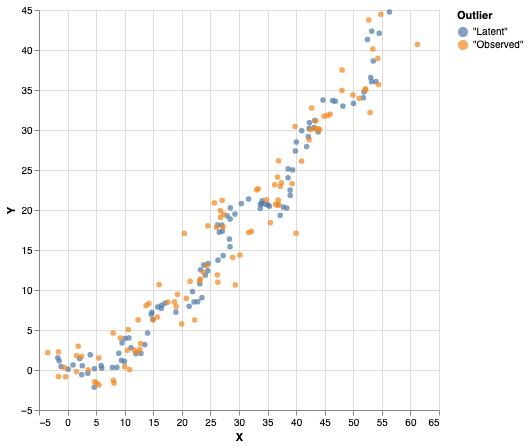

In [9]:
(xs, ys, xs', ys') <- sampleIOfixed $ unzip4 <$> toList observations

plotVega 
    (zip (zip (xs <> xs') (ys <> ys')) 
    (replicate 100 (T.pack "Latent") <> replicate 100 (T.pack "Observed")))

We now have a dataset, as shown by the orange dots. The goal is to infer the positions of the actual random walk (the true values that generated the dataset are shown in blue).

In [10]:
-- take the original random walk as a prior and condition on the observations
-- to obtain a posterior random walk
conditioning :: (MonadSample m, MonadCond m) => P.Producer (Double,Double) m ()
conditioning = 
    P.zip walk (P.each (zip xs' ys')) 
    >-> P.chain (\((x,y), (x',y')) -> factor (normalPdf x 2 x' * normalPdf y 2 y' ))
    >-> P.map fst 

model :: MonadInfer m => m [(Double,Double)]
model = toList conditioning

`model` is the distribution we want to perform inference on.

The intuition of the problem is that we need to guess the whole path, by taking into account not just the observation at each timestep, but the relation (expressed in the prior) of the inferred position at that timestep to the previous and subsequent ones.

To perform approximate inference here, we can represent a distribution as a *population* of weighted samples, and at each factor statement, do a resampling operation to keep the population "healthy". This is **Sequential Monte Carlo**. 

<!-- The algorithm creates a population of $n$ samples (initially weighted equally) and updates them at each factor statement. The update is defined by `smcMultinomial`, which samples new samples from the empirical distribution defined by the population. More sophisticated resamplers are available, including `smcSystematic` (see TODO) -->

In [11]:
smcRes <- sampleIOfixed $ runPopulation $ smcMultinomial 100 1000 model

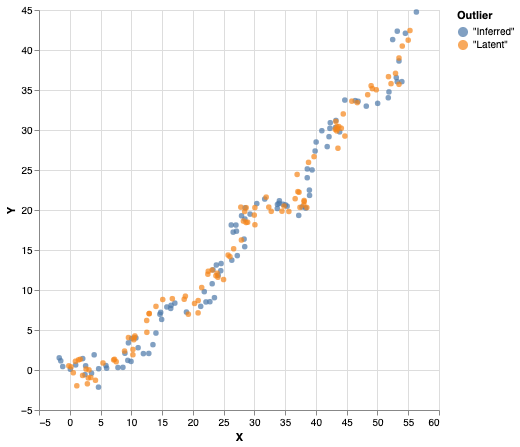

In [12]:
(inferredXs, inferredYs) = unzip $ fst =<< smcRes

plotVega 
    (zip (zip (xs <> inferredXs) (ys <> inferredYs)) 
    (replicate 100 (T.pack "Inferred") <> replicate 100 (T.pack "Latent")))

We can see here that `SMC` has done an ok job.

The intuition of how SMC does well is that it is searching the space of solutions with some backtracking (because it has a whole population of guesses to rely on), and moreover, this search results in unbiased sampling from the distribution of interest. So if it makes a series of guesses the leads it astray, it can throw away this possiblity at a later stage. 

In [33]:
-- import Control.Monad.IO.Class
-- import Control.Monad.Bayes.Sequential
-- import Numeric.Log
-- import Control.Monad.Identity

-- resampleMultinomialWithTrace x = fromWeightedList $ do
--     y <- runPopulation $ resampleMultinomial x
--     liftIO $ print $ nub $ fmap snd y
--     return y
    
-- -- model2 = replicateM 10 do
-- --     x <- random
-- --     factor (Exp $ log x)
-- --     return x 
-- sampleIO $ runPopulation $ resampleMultinomial $ fromWeightedList $ pure $ take 200 $ cycle [(1, 0.0), (2, 0.4), (3, 0.3)]

-- smcRes <- sampleIOfixed $ runPopulation $ sir resampleMultinomialWithTrace 100 20 (model)